<a href="https://colab.research.google.com/github/vidhirawat10/RealEyes/blob/main/audio_detection_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
import IPython.display as ipd
import keras
import librosa
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import tensorflow as tf

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape

dataset

In [ ]:
import kagglehub

In [ ]:
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mohammedabdeldayem/the-fake-or-real-dataset/versions/2


directory initialization

In [ ]:
train_real_directory = os.path.join(path, "for-2sec/for-2seconds/training/real")
train_fake_directory = os.path.join(path, "for-2sec/for-2seconds/training/fake")

validation_real_directory = os.path.join(path, "for-2sec/for-2seconds/validation/real")
validation_fake_directory = os.path.join(path, "for-2sec/for-2seconds/validation/fake")

test_real_directory = os.path.join(path, "for-2sec/for-2seconds/testing/real")
test_fake_directory = os.path.join(path, "for-2sec/for-2seconds/testing/fake")

getting waveform (.wav) audio files

In [ ]:
train_real_audio = [os.path.join(train_real_directory, file) for file in os.listdir(train_real_directory) if file.endswith('.wav')]
train_fake_audio = [os.path.join(train_fake_directory, file) for file in os.listdir(train_fake_directory) if file.endswith('.wav')]

validation_real_audio = [os.path.join(validation_real_directory, file) for file in os.listdir(validation_real_directory) if file.endswith('.wav')]
validation_fake_audio = [os.path.join(validation_fake_directory, file) for file in os.listdir(validation_fake_directory) if file.endswith('.wav')]

test_real_audio = [os.path.join(test_real_directory, file) for file in os.listdir(test_real_directory) if file.endswith('.wav')]
test_fake_audio = [os.path.join(test_fake_directory, file) for file in os.listdir(test_fake_directory) if file.endswith('.wav')]

In [ ]:
# Take a random audio file
random_audio_file = train_real_audio[random.randint(0, 6977)]
ipd.Audio(random_audio_file)


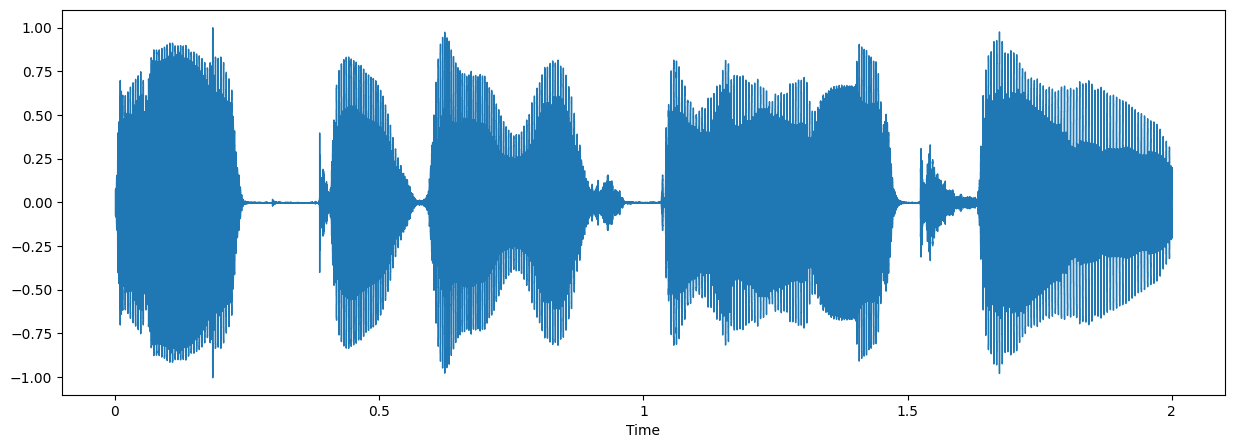

In [ ]:
# visulazing waveform of above sample audio
audio_data, sample_rate = librosa.load(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

converting audio file to mel-scale spectrogram

In [ ]:
def create_mel_spectrogram(file_path):
    audio_data, sample_rate = librosa.load(file_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)  # audio to mel-based spectrogram

    mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)       #from amplitude squared to decibel units
    return mel_decibel_spectrogram

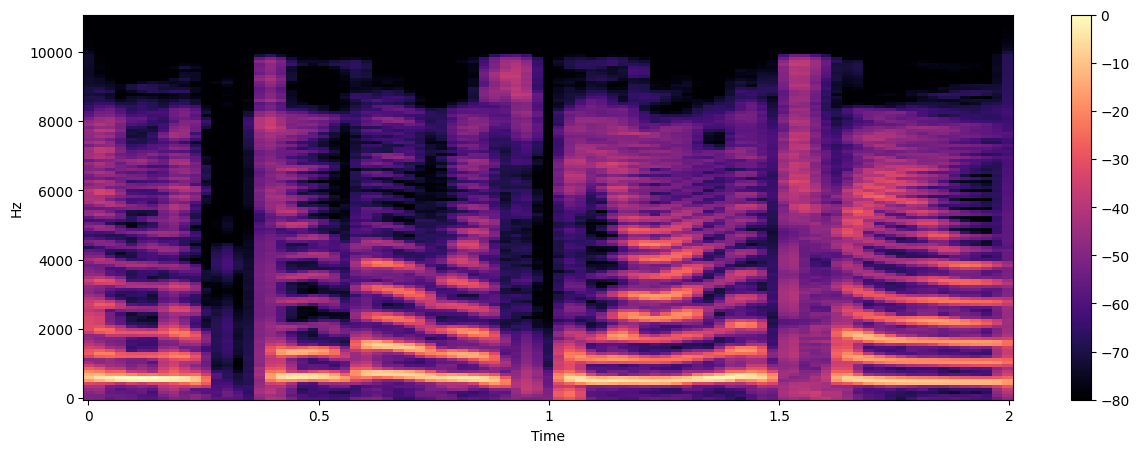

In [ ]:
# spectrogram representation of sample wave
sample_spectrogram = create_mel_spectrogram(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.specshow(sample_spectrogram, x_axis='time', y_axis='hz')
plt.colorbar()

now we will use spectrograms as features to train the model

In [ ]:
def get_features_and_labels(real_audio_files, fake_audio_files):
    spec_arr = []
    labels = []

    for file in real_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(0)
    for file in fake_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(1)

    return np.array(spec_arr), np.array(labels)

train_features, train_labels = get_features_and_labels(train_real_audio, train_fake_audio)
validation_features, validation_labels = get_features_and_labels(validation_real_audio, validation_fake_audio)
test_features, test_labels = get_features_and_labels(test_real_audio, test_fake_audio)

now we can use CNNs like in our deepfake video detection
as we have converted audio into images ( spectrogram ) for machine learning

In [ ]:
print("train features shape: {}".format(train_features.shape))
print("test features shape: {}".format(test_features.shape))

train features shape: (13956, 128, 87)
test features shape: (1088, 128, 87)


In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape
from keras.initializers import HeNormal

In [ ]:
# trimmed VGG model to optimize results

trimmed_vgg = Sequential()
trimmed_vgg.add(Reshape((128, 87, 1),input_shape=train_features.shape[1:]))

trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Flatten())
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(1, activation="sigmoid"))


trimmed_vgg.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 128, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 87, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 87, 64)         │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 43, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86016)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,020,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,345,409 (85.24 MB)

 Trainable params: 22,345,409 (85.24 MB)

 Non-trainable params: 0 (0.00 B)

Compile model

In [ ]:
from tensorflow.keras.optimizers import Adam

trimmed_vgg.compile(optimizer=Adam(learning_rate=0.002),
                    loss=keras.losses.binary_crossentropy,
                    metrics=["accuracy"])

In [ ]:
trimmed_vgg_history = trimmed_vgg.fit(train_features,
                                      train_labels,
                                      validation_data = [validation_features, validation_labels],
                                      batch_size = 8,
                                      epochs = 5,
                                      steps_per_epoch = 90)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.5484 - loss: 26.0532 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.4944 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.4867 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6933


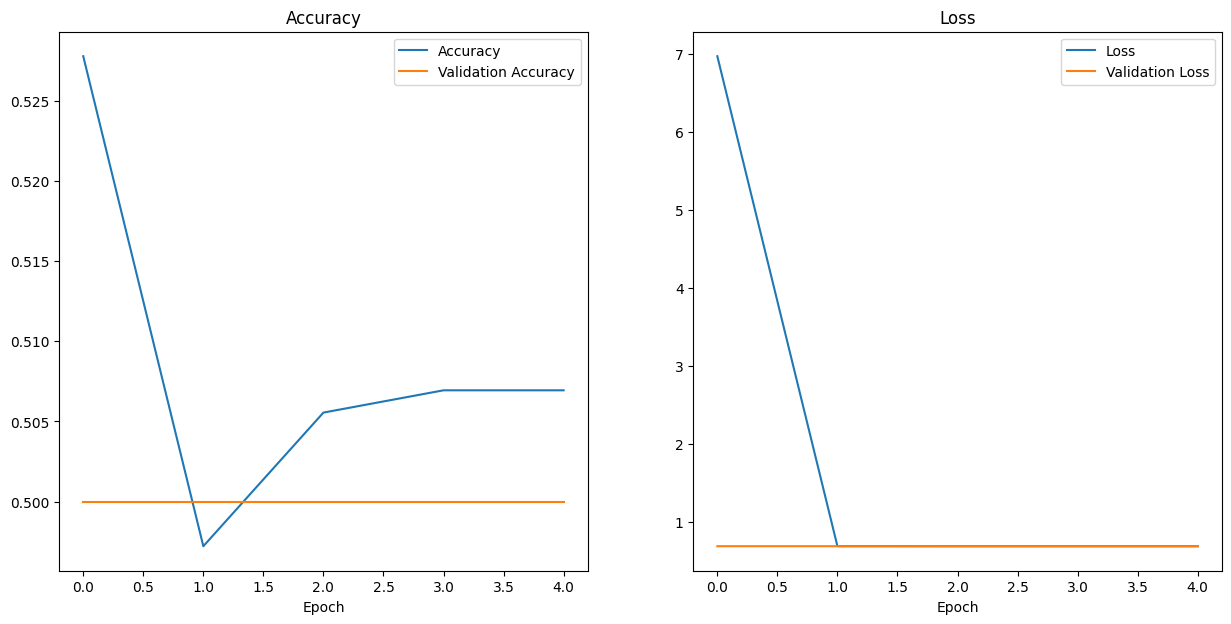

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(trimmed_vgg_history.history["accuracy"])
ax1.plot(trimmed_vgg_history.history['val_accuracy'])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy"])

ax2.plot(trimmed_vgg_history.history["loss"])
ax2.plot(trimmed_vgg_history.history["val_loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Loss","Validation Loss"])

plt.show()

In [ ]:
trimmed_vgg_loss, trimmed_vgg_accuracy = trimmed_vgg.evaluate(test_features, test_labels)

34/34 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8296 - loss: 0.6818


In [ ]:
trimmed_vgg.save('deepfake_audio_detector.h5')

#Test Model

In [ ]:
from keras.models import load_model
import librosa
import numpy as np

In [ ]:
def create_mel_spectrogram(audio_file_path):

    audio_data, sample_rate = librosa.load(audio_file_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_decibel_spectrogram

In [ ]:
def predict_audio(audio_file_path):

    spectrogram = create_mel_spectrogram(audio_file_path)
    spectrogram = spectrogram.reshape((1, 128, 87, 1))

    loaded_model = load_model('deepfake_audio_detector.h5')
    prediction = loaded_model.predict(spectrogram)

    if prediction[0][0] < 0.5:
        return "Real"
    else:
        return "Deepfake"

In [ ]:
# Example usage (optional):
# test_audio_file = "path/to/your/test/audio.wav"
# prediction = predict_audio(test_audio_file)
# print(f"The audio file '{test_audio_file}' is predicted to be: {prediction}")